In [122]:
from importlib import reload
import flymovie as fm
import cnn_models.siamese_cnn as cn
import cnn_models.evaluate_models as ev
from flymovie.simnuc import Sim
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import sklearn
import tempfile
import pickle
import tensorflow as tf
import umap
from importlib import reload
from sklearn.manifold import TSNE
import scipy.ndimage as ndi
import skimage as ski
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
import sklearn.decomposition
def pca3d(embeddings, alpha=1, use_combined=False):
    combined = np.vstack(embeddings)
    pca = sklearn.decomposition.PCA(n_components=3)
    if use_combined:
        pca.fit(combined)
    else:
        pca.fit(embeddings[0])
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(len(embeddings)):
        if i == 0:
            alpha_plot = 0
        else:
            alpha_plot = alpha
        tfm = pca.transform(embeddings[i])
        ax.scatter(tfm[:,0], tfm[:,1], tfm[:,2], 
                alpha=alpha_plot)
    
def save_list(l, outfolder):
    if not os.path.exists(outfolder):
        os.mkdir(outfolder)
    count = 1
    for arr in l:
        
        fake_id = 'aaa_'
        fake_params = [str(round(x, 2)) for x in np.random.random(9)]
        filepath = os.path.join(outfolder, fake_id + '_'.join(fake_params) + '.pkl')
        fm.save_pickle(arr, filepath)
        count += 1

def load_folder(folder):
    ims = []
    for f in sorted(os.listdir(folder)):
        if f[0] == '.':
            continue
        im = fm.load_pickle(os.path.join(folder, f))
        ims.append(im)
    return ims

def process(mat, n):
    v = mat.copy()
    # Subtract mean.
    v = v - v.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(v)
    # Subtract off the first n components.
    tfm = pca.transform(v)
    print(tfm.shape)
    for i in range(n):
        vp = np.outer(tfm[:,i], pca.components_[i])
        v = v - vp
    return v

# Same, written with vectors. Confirmed output is the same as process.
def process2(mat_in, n):
    mat = mat_in.copy()
    # Subtract mean.
    mat = mat - mat.mean(axis=0)
    # Fit n PCA components.
    pca = sklearn.decomposition.PCA(n_components=n)
    pca.fit(mat)
    # Subtract off the first n components.
    #tfm = pca.transform(v)
    for r in range(mat.shape[0]):
        v = mat[r]
        for i in range(n):
            comp = pca.components_[i]
            #comp = np.expand_dims(comp, 1) # column vector
            vp = np.dot(comp, v)
            vp = vp * comp
            v = v - vp

        mat[r, :] = v
    return mat

def match_idxs(files, pattern):
    return [x for x in np.arange(len(files)) if re.search(pattern, files[x])]


def combine_embeddings(outfilestem, infilestems):

    # Merge embeddings.
    merged = np.genfromtxt(fname=infilestems[0] + '_embeddings.tsv', delimiter="\t")
    filenames = np.genfromtxt(fname=infilestems[0] + '_filenames.tsv', delimiter="\t", dtype='str')

    for n in range(1, len(infilestems)):
        new = np.genfromtxt(fname=infilestems[n] + '_embeddings.tsv', delimiter="\t")
        merged = np.vstack((merged, new))

        newfiles = np.genfromtxt(fname=infilestems[n] + '_filenames.tsv', dtype='str', delimiter='\t')
        filenames = np.concatenate((filenames, newfiles))

    np.savetxt(outfilestem + '_embeddings.tsv', merged, delimiter='\t')
    np.savetxt(outfilestem + '_filenames.tsv', filenames, delimiter='\t', fmt="%s")
    
    return merged, filenames


def save_embeddings(outfilepath, embeddings, filenames):
    np.savetxt(outfilepath + '_embeddings.tsv', embeddings, delimiter='\t')

    with open(outfilepath + '_filenames.tsv', 'w') as filenames_file:
        for f in filenames:
            if f[0] == '.':
                continue
            filenames_file.write(f + '\n')

In [266]:
weights_file = '/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/trained_models/checkpoint_final_mix_real_sim_2'
base_cnn = cn.make_base_cnn_3d(image_shape=(34,100,100), nlayers=8)
embedding = cn.make_embedding(base_cnn)
embedding.load_weights(weights_file)

In [77]:
#e = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/all', embedding, return_params=False)
#e, ims, files = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2', embedding, return_params=False, return_stack=True)
#e, ims, files = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2/bcd', embedding, return_params=False, return_stack=True)
#e_h2b, ims_h2b = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/h2b', embedding, return_params=False, return_stack=True)
e = np.genfromtxt('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix3_embeddings.tsv', delimiter='\t')
files = np.genfromtxt('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix3_filenames.tsv', delimiter='\t', dtype='str')

In [112]:
#pca = sklearn.decomposition.PCA(n_components=1)
#pca.fit(e)
#pca.explained_variance_ratio_

e_processed = e - e.mean(axis=0)
e_processed = process(e_processed, 1)

#e_processed= e

(5109, 1)


In [113]:
#dr = TSNE(n_components=2, learning_rate='auto', perplexity=50, init='random').fit_transform(e_processed)
reducer = umap.UMAP(n_neighbors=100, min_dist=0.5).fit(e_processed)
dr = reducer.transform(e_processed)

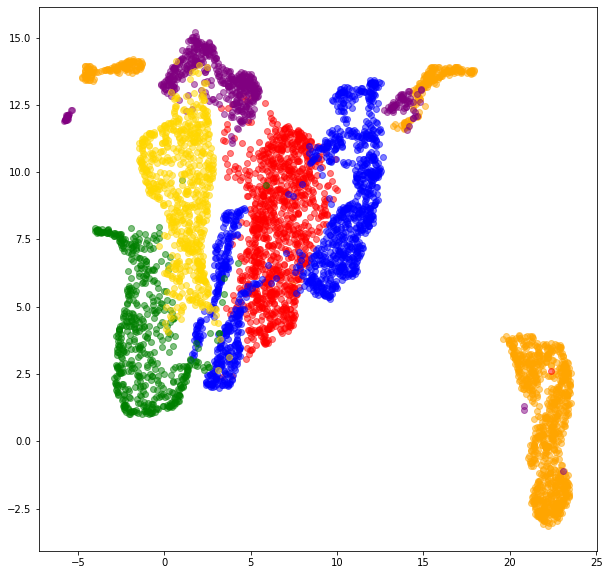

In [119]:
#reducer = umap.UMAP(n_neighbors=10, min_dist=0.1).fit(e_processed)
#dr = reducer.transform(e_processed)
i=match_idxs(files, 'rpb1_2')
j=match_idxs(files, 'rpb1_sim')
k=match_idxs(files, 'h2b_2')
l=match_idxs(files, 'h2b_sim')
m=match_idxs(files, 'zld_2')
n=match_idxs(files, 'zld_sim')

#print(np.array(files)[i])
plt.figure(figsize=(10,10))
#plt.scatter(dr[:,0], dr[:,1], c="blue", alpha=0.1)
plt.scatter(dr[i,0], dr[i,1], c="orange", alpha=0.5)
plt.scatter(dr[j,0], dr[j,1], c="red", alpha=0.5)
plt.scatter(dr[k,0], dr[k,1], c="blue", alpha=0.5)
plt.scatter(dr[l,0], dr[l,1], c="green", alpha=0.5)
plt.scatter(dr[m,0], dr[m,1], c="purple", alpha=0.5)
plt.scatter(dr[n,0], dr[n,1], c="gold", alpha=0.5)

#fm.viewer(ims[j].max(axis=1) * 1000, 5)

In [168]:
#kernel=fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/PSFs/psf_20220210_21x25x25pixels_100x50x50voxel.pkl')
masks_og = fm.load_pickle('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_masks/mask_files/nc13_1.pkl')

mask = Sim.make_spherical_mask(100,100,100,42)
sim = Sim(mask)
eroded_coords = sim.get_eroded_coordinates(9)
hlb_possible_coords = list(zip(eroded_coords[0], eroded_coords[1], eroded_coords[2]))

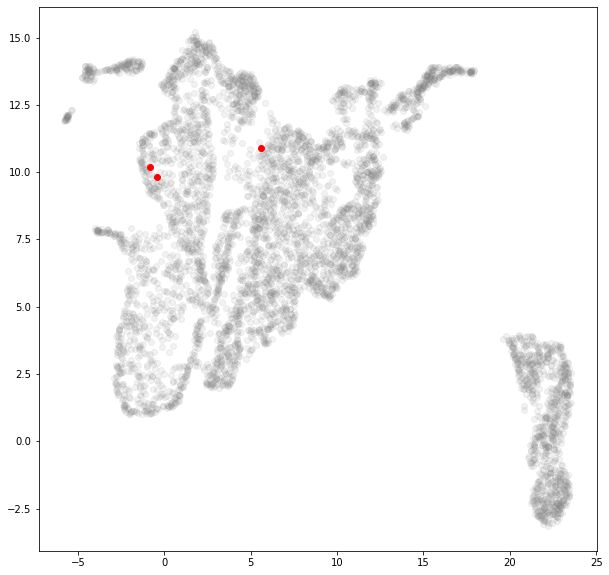

interactive(children=(Dropdown(description='Color', index=2, options=('prism', 'gray_r', 'cividis', 'inferno',…

In [174]:
outfolder = ''
nreps = 1
nfree_rng = [18_000, 18_000]
hlb_diam_rng = [16,16]
hlb_nmols_rng = [400,400]
n_clusters_rng = [1,1]
cluster_diam_mean_rng = [2,2] 
cluster_diam_var_rng = [0.7,0.7]
cluster_nmols_mean_rng = [4,4]
cluster_nmols_var_rng = [3,3]
noise_sigma_rng = [0.6,0.6]
dims_init=(85, 85, 85)
dims_kernel=(100,50,50)
dims_final=(250,85,85)

hlb_coords = [hlb_possible_coords[x] for x in np.random.choice(len(hlb_possible_coords), 2)]
#hlb_coords = [(12, 60, 38), (21, 57, 41)]
sims = []
nsims=3
for _ in range(nsims):
    masks = masks_og[np.random.choice(np.arange(len(masks_og)), nsims)]
    sim = fm.sim_rpb1(masks, kernel, outfolder, nreps, nfree_rng, hlb_diam_rng, 
        hlb_nmols_rng, n_clusters_rng, cluster_diam_mean_rng, 
        cluster_diam_var_rng, cluster_nmols_mean_rng, cluster_nmols_var_rng,
        noise_sigma_rng, hlb_coords, dims_init, 
        dims_kernel, dims_final, return_sim=True, mask_nuclei=True)
    sims.append(sim.im)

with tempfile.TemporaryDirectory() as tdir:
    for i in range(len(sims)):
        tf = os.path.join(tdir, str(i) + '_1.pkl')
        fm.save_pickle(sims[i], tf)
        
    e_new = ev.embed_images(tdir, embedding, return_params=False, return_stack=False)[0]

dr_new = reducer.transform(e_new)
plt.figure(figsize=(10,10))
plt.scatter(dr[:,0], dr[:,1], c="gray", alpha=0.1)
plt.scatter(dr_new[:,0], dr_new[:,1], c="red", alpha=1)

fm.viewer(np.array(sims), 5)


In [142]:
e.shape

(5109, 256)

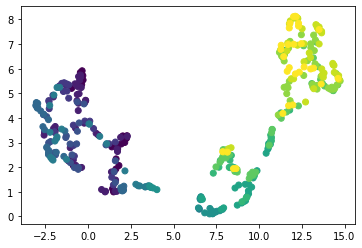

In [389]:
e2 = dr.copy()
e2 = np.hstack((e2, np.zeros((e2.shape[0],1))))
for d in range(28, 41):
    i=match_idxs(files, 'em2-' + str(d))
    e2[i,-1] = d
    
plt.scatter(e2[:,0], e2[:,1], c=e2[:,2], alpha=1)


In [393]:
e, ims = ev.embed_images('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/set2/bcd', embedding, return_params=False, return_stack=True, return_files=False)


In [276]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', e, files)

In [247]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_real', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_sims', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_sims'
]
)

In [284]:
def sortcolors(embeddings, files, target_tag, n_neighbors=None):
    if n_neighbors is None:
        n_neighbors = embeddings.shape[0]
    count = 0
    tags = []
    tag_ids = {}
    for f in files:
        tag = f.split('_')[0]
        if tag not in tag_ids:
            tag_ids[tag] = count
            count += 1
        tags.append(tag)
    
    tags = np.array(tags)
    tag_idxs = [x for x in np.arange(len(files)) if re.search(target_tag, files[x])]
    
    mat = np.ndarray((0, n_neighbors))
    for idx in tag_idxs:
        dists = np.sum((embeddings - embeddings[idx]) ** 2, axis=1)
        tags_sorted = tags[np.argsort(dists)[:n_neighbors]]
        ids = [tag_ids[x] for x in tags_sorted] 
        ids = np.expand_dims(np.array(ids), axis=0)
        mat = np.vstack((mat, ids))  
    
    return mat, tag_ids
    
#mat = sortcolors(em, fs, 'rpb',30)
        


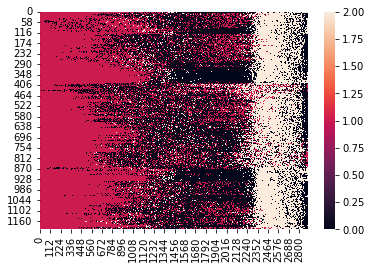

In [248]:
mat, tag_ids = sortcolors(em, fs, 'h2b')
print(tag_ids)
sns.heatmap(mat)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tempfigs/h2b.png', dpi=300)

In [250]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1_sims', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b_sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld_sims'
]
)

{'rpb1': 0, 'h2b': 1, 'zld': 2}


<AxesSubplot:>

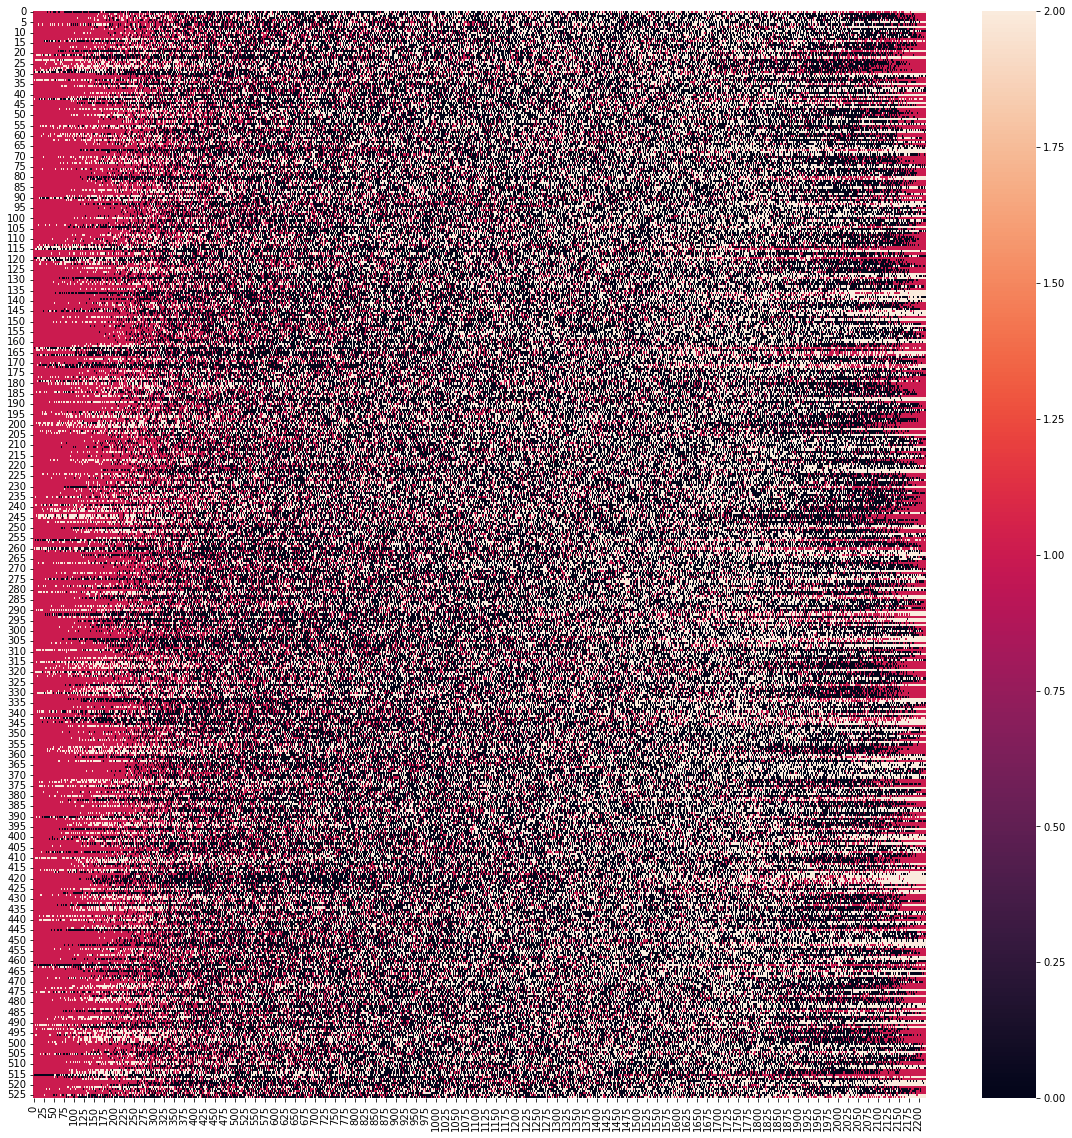

In [253]:
mat, ids = sortcolors(em, fs, 'h2b')
print(ids)
plt.figure(figsize=(20,20))
sns.heatmap(mat)

{'rpb1-real': 0, 'rpb1-sim': 1}


<AxesSubplot:>

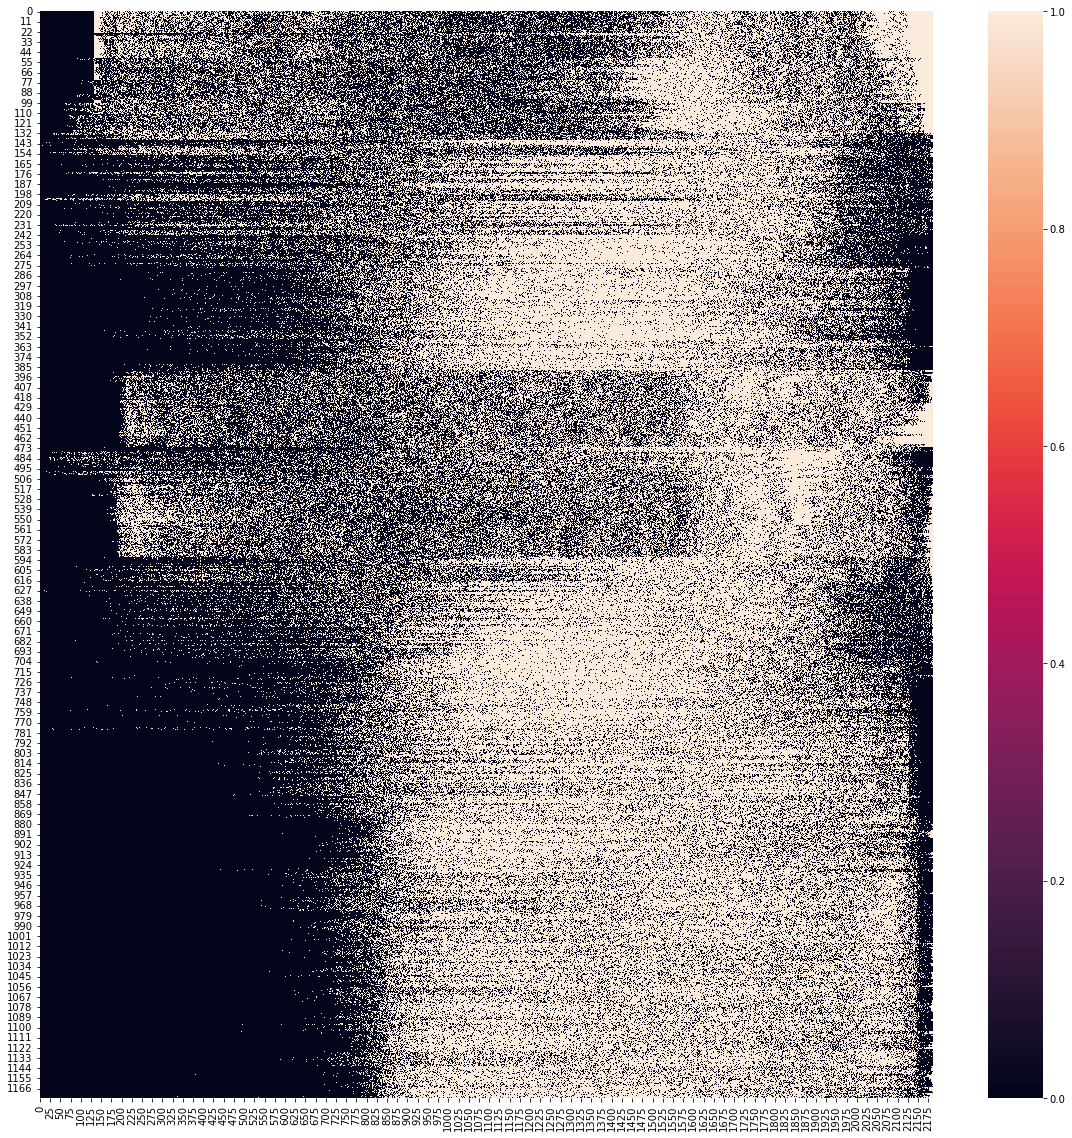

In [300]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-sims',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-sims'
]
)

mat, tags = sortcolors(em, fs, 'rpb1-real')
print(tags)
plt.figure(figsize=(20,20))
sns.heatmap(mat)

In [299]:
save_embeddings('/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/mix-rpb1-real-sims', em, fs)

{'rpb1-sim': 0, 'zld-real': 1}


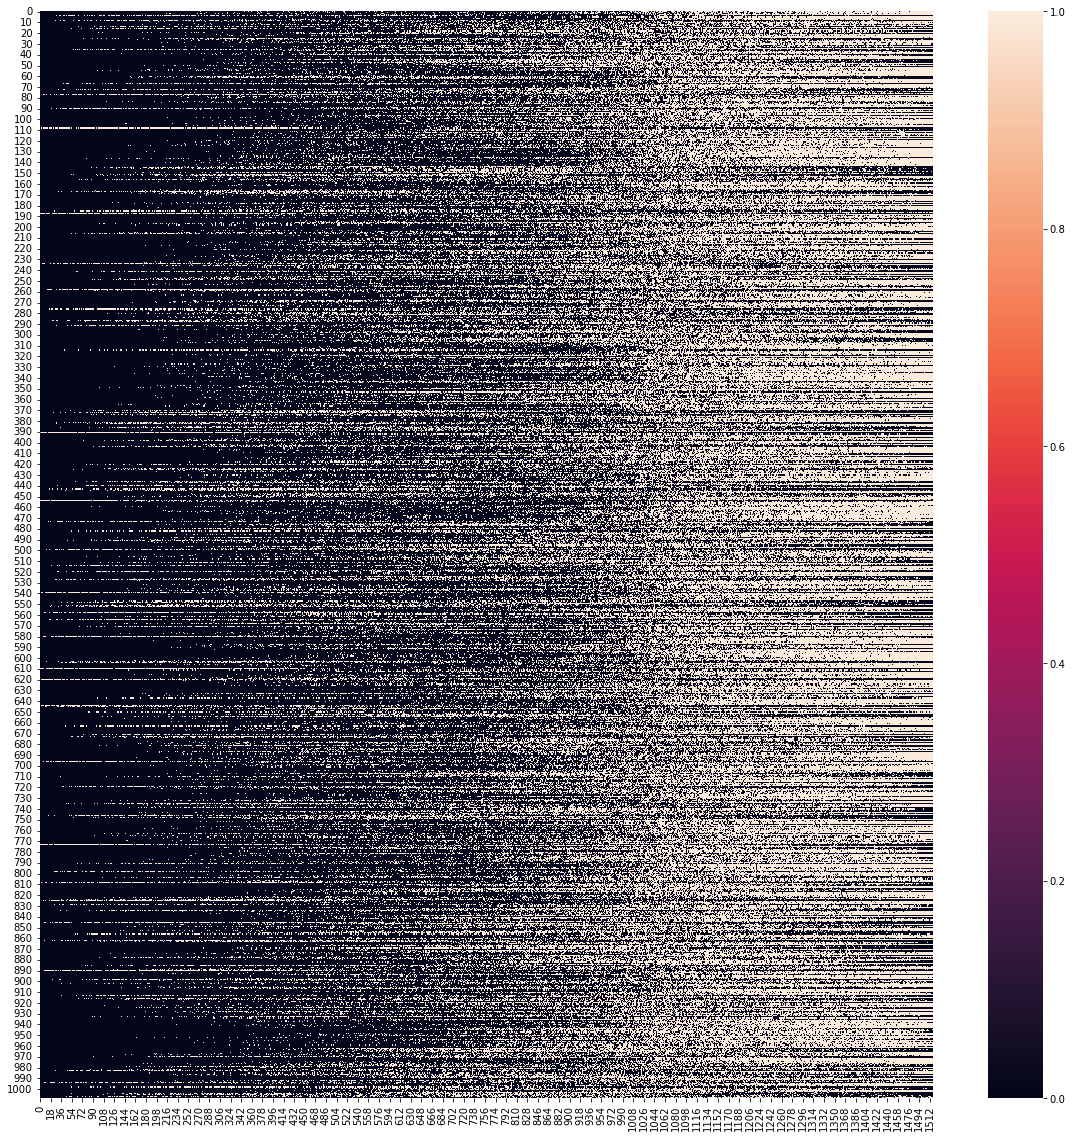

In [296]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/reals_rpb1_h2b_zld',
[
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims', 
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-sims',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
#'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-sims'
]
)

mat, tags = sortcolors(em, fs, 'rpb1-sim')
print(tags)
plt.figure(figsize=(20,20))
sns.heatmap(mat)
plt.savefig('/Users/michaelstadler/Bioinformatics/Projects/rpb1/results/tempfigs/temp.png', dpi=300)

In [377]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/temp',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/h2b-real',
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/zld-real',
]
)

In [378]:
def get_dist_distros(em, files):
    def dists_arr_to_row(arr, row):
        dists_sq = np.sum((arr - row) ** 2, axis=1)
        dists = np.sqrt(dists_sq)
        return dists

    tags = []
    datasets = []
    for f in files:
        tag, dataset = f.split('_')[:2]
        tags.append(tag)
        datasets.append(dataset)
    
    tags = np.array(tags)
    datasets = np.array(datasets)
    dists_same_ds = np.array([])
    dists_diff_tag = np.array([])
    min_dists = []

    for i in range(len(files)):
        if i % 250 == 0:
            pass
            #print(i)
        tag = tags[i]
        dataset = datasets[i]
        em_ref = em[i]

        min_dist = sorted(dists_arr_to_row(em, em_ref))[1]
        min_dists.append(min_dist)

        em_diff_tag = em[tags != tag]
        em_same_ds = em[datasets == dataset]

        all_dists_diff_tag = dists_arr_to_row(em_diff_tag, em_ref)
        sampled_dists_diff_tag = np.random.choice(all_dists_diff_tag, size=100, replace=False)
        dists_diff_tag = np.concatenate((dists_diff_tag, sampled_dists_diff_tag))

        dists_same_ds = np.concatenate((dists_same_ds, dists_arr_to_row(em_same_ds, em_ref)))

    return dists_diff_tag, dists_same_ds, np.array(min_dists)


    
diff_tag, same_ds, mins = get_dist_distros(em, fs)

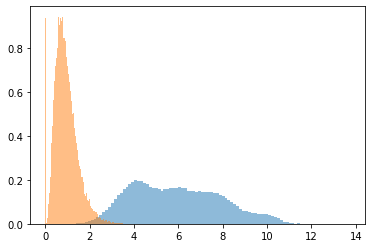

In [379]:
#plt.hist(mins, bins=100, density=True, alpha=0.5);
plt.hist(diff_tag, bins=100, density=True, alpha=0.5);
plt.hist(same_ds, bins=100, density=True, alpha=0.5);

In [380]:
em, fs = combine_embeddings(
    '/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/temp',
[
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-real', 
'/Users/michaelstadler/Bioinformatics/Projects/rpb1/data/real_nuclei/embeddings/rpb1-sims'
]
)

In [388]:
def find_in_radius(em, files, tag1, tag2, r):
    def dists_arr_to_row(arr, row):
        dists_sq = np.sum((arr - row) ** 2, axis=1)
        dists = np.sqrt(dists_sq)
        return dists

    tags = []
    datasets = []
    for f in files:
        tag, dataset = f.split('_')[:2]
        tags.append(tag)
        datasets.append(dataset)

    tags = np.array(tags)
    datasets = np.array(datasets)
    hits = {}

    for i in range(len(files)):
        if i % 250 == 0:
            print(i)

        file = files[i]
        tag = tags[i]
        em_ref = em[i]

        if tag == tag1:
            dists = dists_arr_to_row(em, em_ref)
            good_uns = (dists <= r) & (tags == tag2)
            good_files = files[good_uns]
            if len(good_files) > 0:
                hits[file] = good_files

    return hits
    
hits = find_in_radius(em, fs, 'rpb1-real', 'rpb1-sim', 0.75)

0
250
500
750
1000
1250
1500
1750
2000


In [390]:
hits

{'rpb1-real_20220318-rpb1-gfp-em1-11_18_5.pkl': array(['rpb1-sim_BWp_17932_11.57_610_16_1_0.86_11_1.04_1.14_rep0.pkl'],
       dtype='<U61'),
 'rpb1-real_20220318-rpb1-gfp-em2-19_8_3.pkl': array(['rpb1-sim_BmH_15993_14.08_435_20_1_0.24_13_1.31_1.11_rep0.pkl'],
       dtype='<U61')}

In [337]:
same_ds = same_ds[same_ds > 0]

In [348]:
np.sum(((em - em[0]) ** 2), axis=1).shape

(3573,)

(3573, 256)